# Calculating the efficiency of a single HLT1 line

This notebook shows how to configure the `HltEff` class from TriggerCalib to calculate the efficiency of a single HLT1 line, with each background mitigation approach.
To run this notebook, you will need to have installed TriggerCalib (`pip install triggercalib`) and have `ROOT` present in the running environment.

_Note that_ `HltEff` _operates based on_ `RDataFrame` _and so can be run multithreaded using the_ `ROOT.EnableImplicitMT()`.

In [1]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import ROOT as R
from triggercalib import HltEff
from triggercalib.utils.helpers import tgraph_to_np

hep.style.use("LHCb2")
R.EnableImplicitMT(8)

Welcome to JupyROOT 6.30/04


In this example we'll use `HltEff` to calculate the TOS efficiencies of the HLT1 line `Hlt1TrackMVA` on $B^+\to J/\psi\left(\mu\mu\right)K^+$ 2024 MC simulation (specifically a prefiltered sample from the [rd_ap_2024](https://lhcb-productions.web.cern.ch/productions/?wg=rd&analysis=rd_ap_2024)).
To purify signal, sideband subtraction is applied, with sidebands of $[5130-5200]~\mathrm{MeV}c^{-2}$ and $[5360-5430]~\mathrm{MeV}c^{-2}$.
This is implemented in the `sideband` argument of `HltEff`.
The efficiencies here will be calculated in bins of $B^+$ transverse momentum, $p_T\left(B^+\right)$, with the binning given as a python dictionary.
The TOS is given as `Hlt1TrackMVA` and the TIS is given as both `Hlt1TrackMVA` and `Hlt1TwoTrackMVA` to improve the available statistics.
The particle `B` which is passed is the particle in the TISTOS information which starts the branch names for the TIS/TOS decisions.
This means that the TIS and TOS are defined in terms of all three final state particles.

In [2]:
binning = {
    "B_PT" : {
        "bins" : [
            2e3,  3e3,  4e3,  5e3,
            6e3,  7e3,  8e3,  9e3,
            10e3, 11e3, 12e3, 13e3,
            14e3, 15e3, 16e3, 17e3,
            18e3, 19e3, 20e3, 21e3,
            22e3, 25e3
        ]
    }
}

sideband = {
    "B_DTF_Jpsi_MASS": {
        "signal": [5220, 5340], # Define the signal window
        "sidebands": [[5130, 5200], [5360, 5430]], # Define two sidebands, one above and one below the signal window
    }
}

hlt_eff = HltEff(
    "simple_example",
    "root://eoslhcb.cern.ch//eos/lhcb/wg/rta/WP4/TriggerCalib/Bu2JpsiK_Jpsi2MuMu_block1_ntuple.root:Tuple/DecayTree",
    tos="Hlt1TrackMVA",
    tis=["Hlt1TrackMVA", "Hlt1TwoTrackMVA"],
    particle="B",
    binning=binning,
    sideband=sideband,
)

Running the cell above gives us a `HltEff` object, `hlt_eff`.
This object contains two results stores: `counts` and `efficiencies`, which can be accessed by indexing with `["counts"]` or `["efficiencies]`, respectively.
Taking a look at the output above, we see that `hlt_eff` initialises, creates an `RDataFrame` defined from the `path` argument and implements the binning from the `binning` argument.
The final two lines are particularly useful for keeping track of what is being done in the backend.
When a `HltEff` object is initialised without the `lazy` argument, two methods are called.

The first method, `counts()`, creates the histogram of event counts.
In the most basic case, this is simply the filling of `ROOT` histograms.
This is extended in the sideband-subtraction mode (as here), where histograms in the background and signal windows are also filled.
These additional histograms are used to then calculate the sideband-subtracted histograms.
In the _experimental_ fit-and-count backend (which can be run by providing the arguments `obs` (`RooFit` `RooAbsReal` type) and `pdf` (`RooFit` `RooAbsPdf` type), the count histograms are filled manually with the values and errors taken from the yields of the fits.
The _experimental_ _sWeight_ backend runs more similarly to the standard histogram filling; wherein global fits are first performed to obtain per-event _sWeights_, which are then passed to the histiogram filling.

The second method, `efficiencies()`, uses the count histograms from the previous stage to calculate the `TOS` ($N_\mathrm{TISTOS}/N_\mathrm{TIS}$), `TIS` ($N_\mathrm{TISTOS}/N_\mathrm{TOS}$) and `Trig` efficiencies (_see [LHCb-PUB-2014-039](https://cds.cern.ch/record/1701134/files/LHCb-PUB-2014-039.pdf)_).

If we want to use per-event weights, _e.g._, from a kinematic reweighting, then all we need to do is pass the name of the branch containing the weights to the argument `weights` in `HltEff`. If this branch is in another `TTree`, this tree can be added as a friend tree by passing it to the `friend` argument in the same form as the input file (note that the branch is then named `<friend_tree>.<branch>` as per the [`ROOT` documentation](https://root.cern/doc/v632/classROOT_1_1RDataFrame.html#friends)).


We can take the `ROOT` `TGraphAsymmErrors` objects directly from `hlt_eff` and plot them in whichever framework we wish.
Here we'll make some conversions (recall `tgraph_to_np` defined above) to get some more familiar pythonic objects and then plot these in `matplotlib`.
The object we're mainly interested in is `tos_efficiency_B_PT` in `efficiencies`, the TOS efficiencies binned in $p_T\left(B^+\right)$ (binned efficiency histograms follow the naming convention `<category>_efficiency_<branch_name>`.

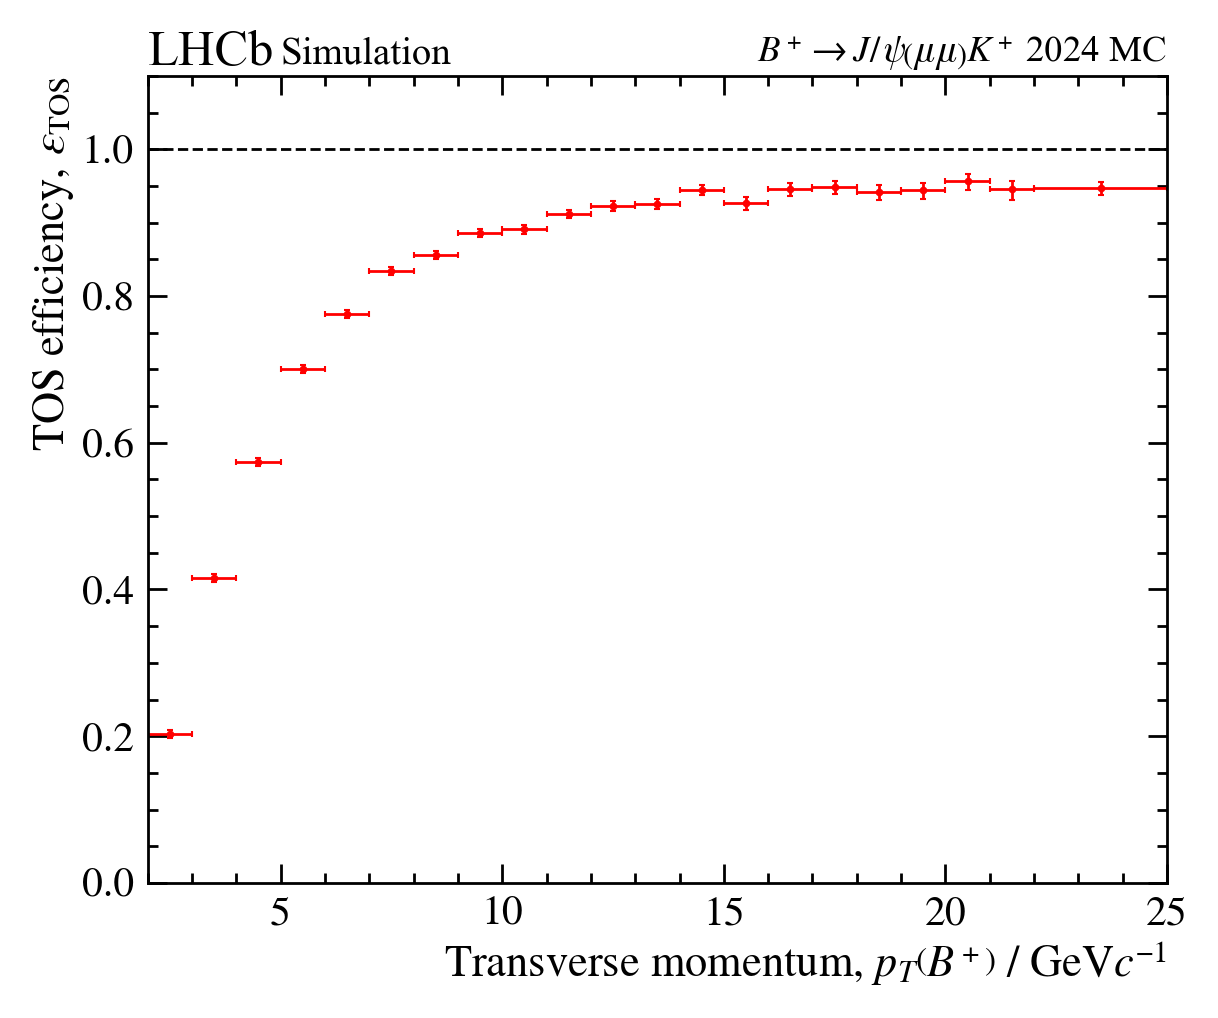

In [3]:
graph = hlt_eff.get_eff("tos_efficiency_B_PT")
xvals, yvals, xerrs, yerrs = tgraph_to_np(graph, xscale=1e-3)
xmin = xvals[0] - xerrs[0][0]
xmax = xvals[-1] + xerrs[1][-1]

# Plot the efficiency #
plt.figure(figsize=(12,10))
plt.gca()

plt.plot((xmin, xmax), (1,1), color='k', ls='dashed', lw=2)
plt.errorbar(
    x=xvals, y=yvals, xerr=xerrs, yerr=yerrs,
    color='r', elinewidth=2, ls="none", marker='.', markersize=8, 
)

plt.xlim(xmin, xmax)
plt.xlabel(r"Transverse momentum, $p_T\left(B^+\right)$ / $\mathrm{GeV}c^{-1}$")

plt.ylim(0, 1.1)
plt.ylabel(r"TOS efficiency, $\varepsilon_\mathrm{TOS}$")

hep.lhcb.label(loc=0, rlabel=r"$B^+\to J/\psi\left(\mu\mu\right)K^+$ 2024 MC")

plt.savefig("tos_efficiencies.pdf")
plt.show()

There we have it!
In a handful of lines, we've calculated TOS efficiencies in MC for a key control channel.
`HltEff` has been designed to be adaptable for a wide range of analysis purposes.
The notebook above should provide a base on which to build your analysis implementation.